In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pprint import pprint

In [14]:
def pix2um(area):
    """Converts area input in px in um^2. 
    
    The downscale_factor is the ratio of the original image size to the downsampled image size. By this factor the orginal scaling is divided to get the new scaling.
    Example: 20 px correspond to 12 um. The image is downscaled by a factor of 2. Then 20 px correspond to 6 um.
    12/20 um/px = 0.6 um/px
    12/20 um/px * 2 = 1.2 um/px
    """

    original_scaling = 200 / 274  # um/px, with 5x magnification
    scale_factor = original_scaling ** 2
    return area * scale_factor


def area2diameter(area):
    """Calculates the diameter of a circle from its area."""
    # return 2 * (area/np.pi)**0.5
    return np.sqrt(area)


def diameter2volume(diameter):
    """Calculates the volume of a sphere from its diameter."""
    return diameter ** 3

In [35]:
data = pd.read_csv('volumes.csv', names=['area_px'])

In [36]:
data['area_um2'] = pix2um(data['area_px'])
data["diameter_um"] = area2diameter(data['area_um2'])
data["volume_um3"] = diameter2volume(data['diameter_um'])
# data = data[data['area_um2'] > 0]


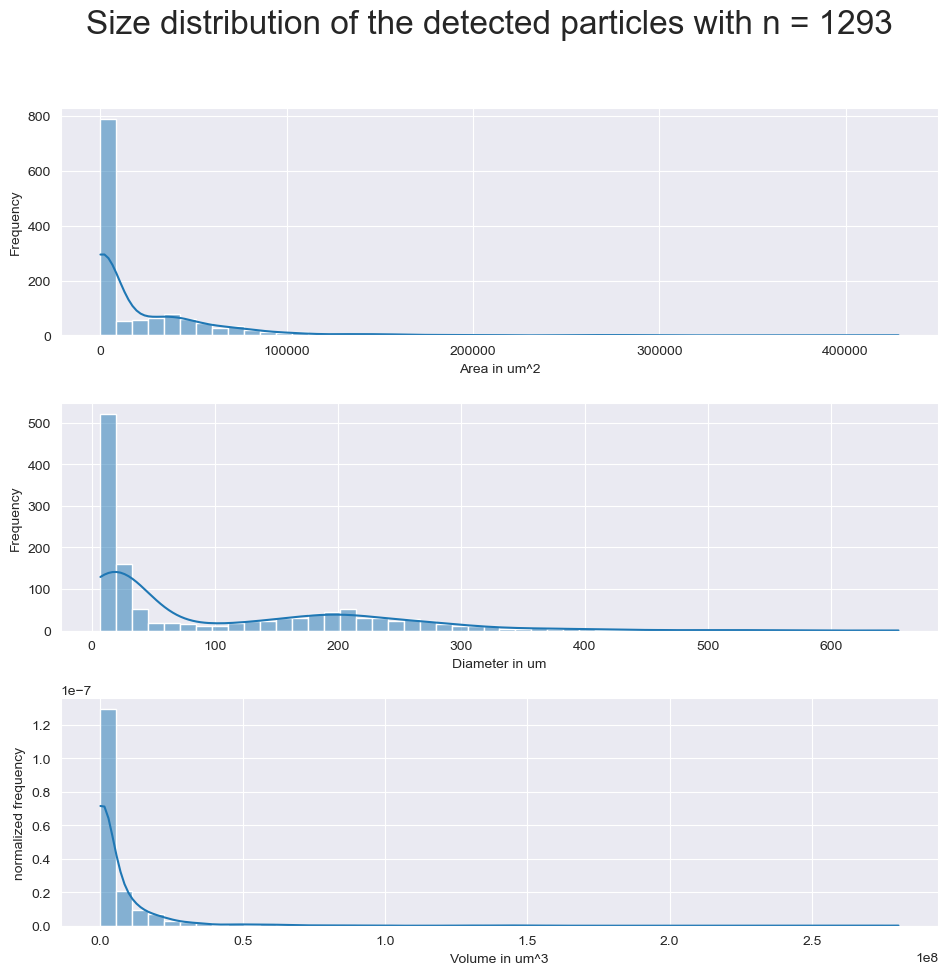

In [37]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
fig.suptitle('Size distribution of the detected particles with n = ' + str(len(data)), fontsize=24)
fig.tight_layout(pad=3.0)
sns.histplot(data['area_um2'], bins=50, ax=axs[0], kde=True)
axs[0].set_xlabel('Area in um^2')
axs[0].set_ylabel('Frequency')

sns.histplot(data['diameter_um'], bins=50, ax=axs[1], kde=True)
axs[1].set_xlabel('Diameter in um')
axs[1].set_ylabel('Frequency')

sns.histplot(data['volume_um3'], bins=50, ax=axs[2], kde=True, stat='density')
axs[2].set_xlabel('Volume in um^3')
axs[2].set_ylabel('normalized frequency')

plt.show()
fig.savefig('size_distribution.png')

In [18]:
def avg_volume(N_i, x_i):
    """Calculates the average volume of the particles from the histogram.
    
    1/N * sum(N_i * x_i^3)
    """

    N = sum(N_i)
    avg_V = 1 / N * (N_i @ x_i ** 3)

    return avg_V


def counts2volume(N_i, x_i):
    """Compute the total volume in each bin.
    
    N_{i, n} = N_i * x_i^3
    """
    
    V_i = N_i * x_i ** 3
    return V_i

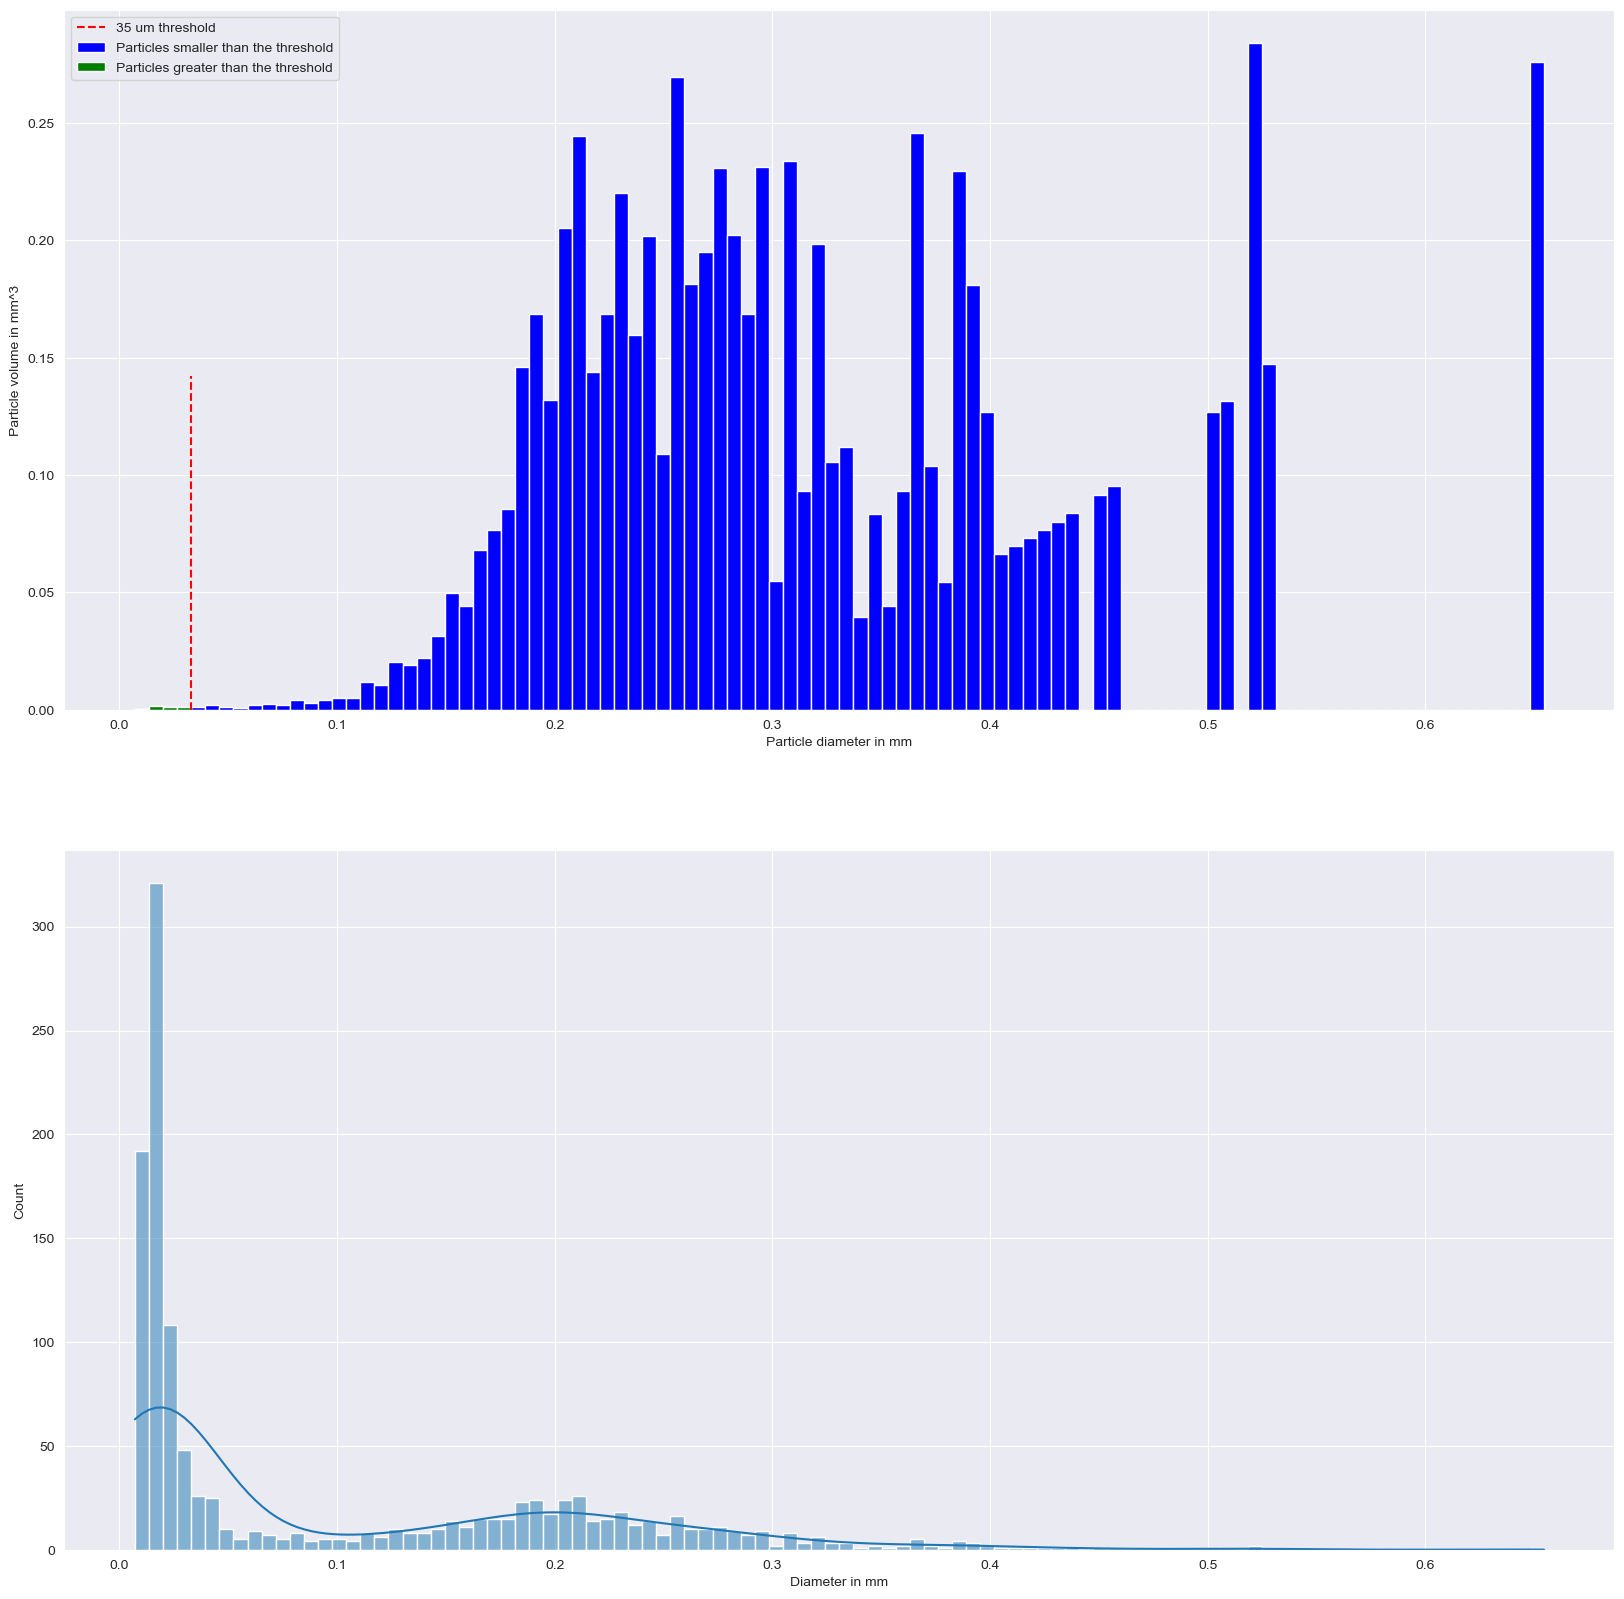

In [19]:
hist = np.histogram(data['diameter_um'], bins=100)
N_i = hist[0]
x_i = (hist[1][:-1] + hist[1][1:]) / 2

V_i = counts2volume(N_i, x_i)
small_particles = np.where(x_i < 35)

# scale to mm and mm^3
x_i = x_i*1e-3
V_i = V_i*1e-9
data['diameter_um'] = data['diameter_um']*1e-3

fig, axs = plt.subplots(2, 1, figsize=(20, 20))
axs[0].bar(x_i, V_i, width=x_i[1] - x_i[0], color='b')
axs[0].bar(x_i[small_particles], V_i[small_particles], width=x_i[1] - x_i[0], color='g')

axs[0].plot(np.tile(x_i[small_particles[0][-1]]+(x_i[1]-x_i[0])/2, 2), [0, max(V_i)*0.5], 'r--')
axs[0].set_xlabel('Particle diameter in mm')
axs[0].set_ylabel('Particle volume in mm^3')
axs[0].legend([
    '35 um threshold',
    'Particles smaller than the threshold',
    'Particles greater than the threshold'
    ], loc='upper left')

sns.histplot(data, x="diameter_um", bins=100, ax=axs[1], kde=True)
axs[1].set_xlabel('Diameter in mm')

axs[1].set_ylabel('Count')

plt.show()

In [20]:
small_particle_V = sum(np.where(x_i < 0.035, V_i, 0))
total_V = sum(V_i)
print('The total volume of particles smaller than 35 um^3 is {:.3f} mm^3, which is {:.2f} % of the total volume V = {:.2f} mm^3.'.format(
    small_particle_V,
    small_particle_V/total_V*100,
    total_V   
    ))

The total volume of particles smaller than 35 um^3 is 0.004 mm^3, which is 0.06 % of the total volume V = 7.46 mm^3.
